# Exercises

In [1]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
!pip install git+https://github.com/flatironinstitute/CaImAn.git
!pip install pims
!pip install zarr
!pip install pynwb
!pip install ipyparallel
!pip install peakutils

  Cloning https://github.com/flatironinstitute/CaImAn.git to /tmp/pip-req-build-xvyv9vw6
  Running command git clone --filter=blob:none --quiet https://github.com/flatironinstitute/CaImAn.git /tmp/pip-req-build-xvyv9vw6
  Resolved https://github.com/flatironinstitute/CaImAn.git to commit 9ea86c77cf7570fac2b631df3533743ae7a211e8
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pims: filename=PIMS-0.6.1-py3-none-any.whl size=82613 sha256=3761d0f26104e7e05d5d8973a6b16ecaee6b49fe5f57be1072c003d2ee668eb8
  Stored in directory: /root/.cache/pip/wheels/cc/bf/3e/bfa77232d942f8244145f9c713b6b38f6ef04b6fb5c021c114
Successfully built pims


In [1]:
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import psutil
from pathlib import Path


# CaImAn funtions and objects
import caiman as cm
from caiman.motion_correction import MotionCorrect, high_pass_filter_space
from caiman.source_extraction.cnmf import params as params
from caiman.source_extraction import cnmf
from caiman.source_extraction.cnmf.cnmf import load_CNMF

import sys
import os
sys.path.append(os.path.abspath("/content/drive/MyDrive/Colab Notebooks/Neuro_Analysis/neural-data/02-calcium_imaging/code"))
from utils import download_data
import auxiliary_functions as aux


import seaborn as sns
sns.set_theme(context='notebook',style='white',font_scale=1.5)


In [2]:
download_data('https://surfdrive.surf.nl/files/index.php/s/HeYXPdvMO87fbq7')

## Exercise 1: Image characteristics
---

**A.** Distiguishing pixels   

Fluctuations in the activitation of the neuron can be directly observed on the video or in a temporal trace plot of each pixel. Plotting the temporal trace will allow us to see the calcium transient dinamic, if a pixel belonging to a neuron is selected.

* Select a set of *N* random pixels from the ROI and plot the temporal evolution of pixel value. If the random pixels are choosen from an active neuron, you will be able to see the calcium transcient dynamic. Try this a few time to appreciate the results.

**B.** Temporal statistics of pixel activation
 * For the selected pixels, plot the histogram of pixel value. What are the difference in different regions?, and how can that help to distinguish a pixel that belongs to aneuron from a background pixel?

* If we can already see the calcium traces from individual pixels, why do we need to run source extraction to segment the neurons? Why, as a starter, would not be a good idea to work directly with the temporal traces of the pixels?

In [14]:
input_tif_file_path_FOV = 'data/calcium_video.tif'
input_tif_file_path = 'data/caiman_video_trial_0.tif'

FOV.play doen't work in collab, as it is brwoser based and not allowed to make popup windows. Below is my approach.

In [29]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def generate_video(movie, interval=50):
    def update(frame):
      p1, p99 = np.percentile(movie[frame, :, :], (1, 99))
      im.set_array(movie[frame, :, :])
      return (im,)
    fig, ax = plt.subplots()
    im = ax.imshow(movie[0, :, :], animated=True)
    frames = movie.shape[0]
    anim = FuncAnimation(fig, update, frames=frames, interval=interval, blit=True)
    plt.close(fig)
    return HTML(anim.to_html5_video())


In [30]:
FOV = cm.load(input_tif_file_path_FOV) # load video with complete field of view (FOV)
display(generate_video(FOV))

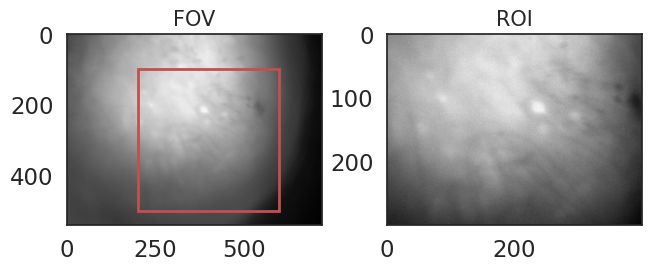

In [52]:
aux.plot_FOV(FOV_file = input_tif_file_path_FOV , ROI_file = input_tif_file_path)

#A.

In [53]:
ROI =  cm.load(input_tif_file_path)

In [96]:
def get_rnd_pixels(array, N, init_coord=np.array([0])):
  if init_coord.all()==0:
    nrows, ncols = array[0].shape
    x, y = np.random.choice(range(nrows), size=N, replace=False), np.random.choice(range(ncols), size=N, replace=False)
  else:
    x, y = init_coord.T[0], init_coord.T[1]
  for i in range(N):
    rnd_pixels = array[:,x, y]
    coord = np.column_stack((x, y))
  return rnd_pixels, coord



In [89]:
saved_coord10=np.array([[108, 226],
                        [  2, 113],
                        [ 91, 208],
                        [ 59, 156],
                        [ 72, 105],
                        [155,  70],
                        [205, 223],
                        [223, 103],
                        [182, 396],
                        [226, 255]])

Text(0, 0.5, 'intensity')

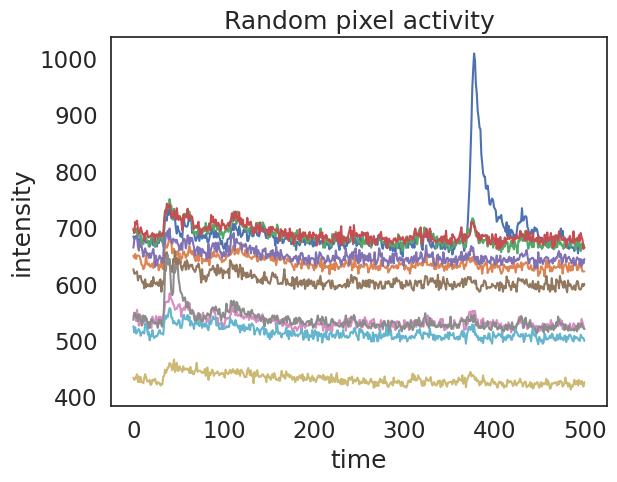

In [98]:
rnd_pix, coord = get_rnd_pixels(ROI, 10, saved_coord10)
plt.title("Random pixel activity")
plt.plot(rnd_pix)
plt.xlabel("time")
plt.ylabel("intensity")

#B.

In [86]:

saved_coord10=np.array([[108, 226],
                        [  2, 113],
                        [ 91, 208],
                        [ 59, 156],
                        [ 72, 105],
                        [155,  70],
                        [205, 223],
                        [223, 103],
                        [182, 396],
                        [226, 255]])
print(saved_coord10.T)

[[108   2  91  59  72 155 205 223 182 226]
 [226 113 208 156 105  70 223 103 396 255]]


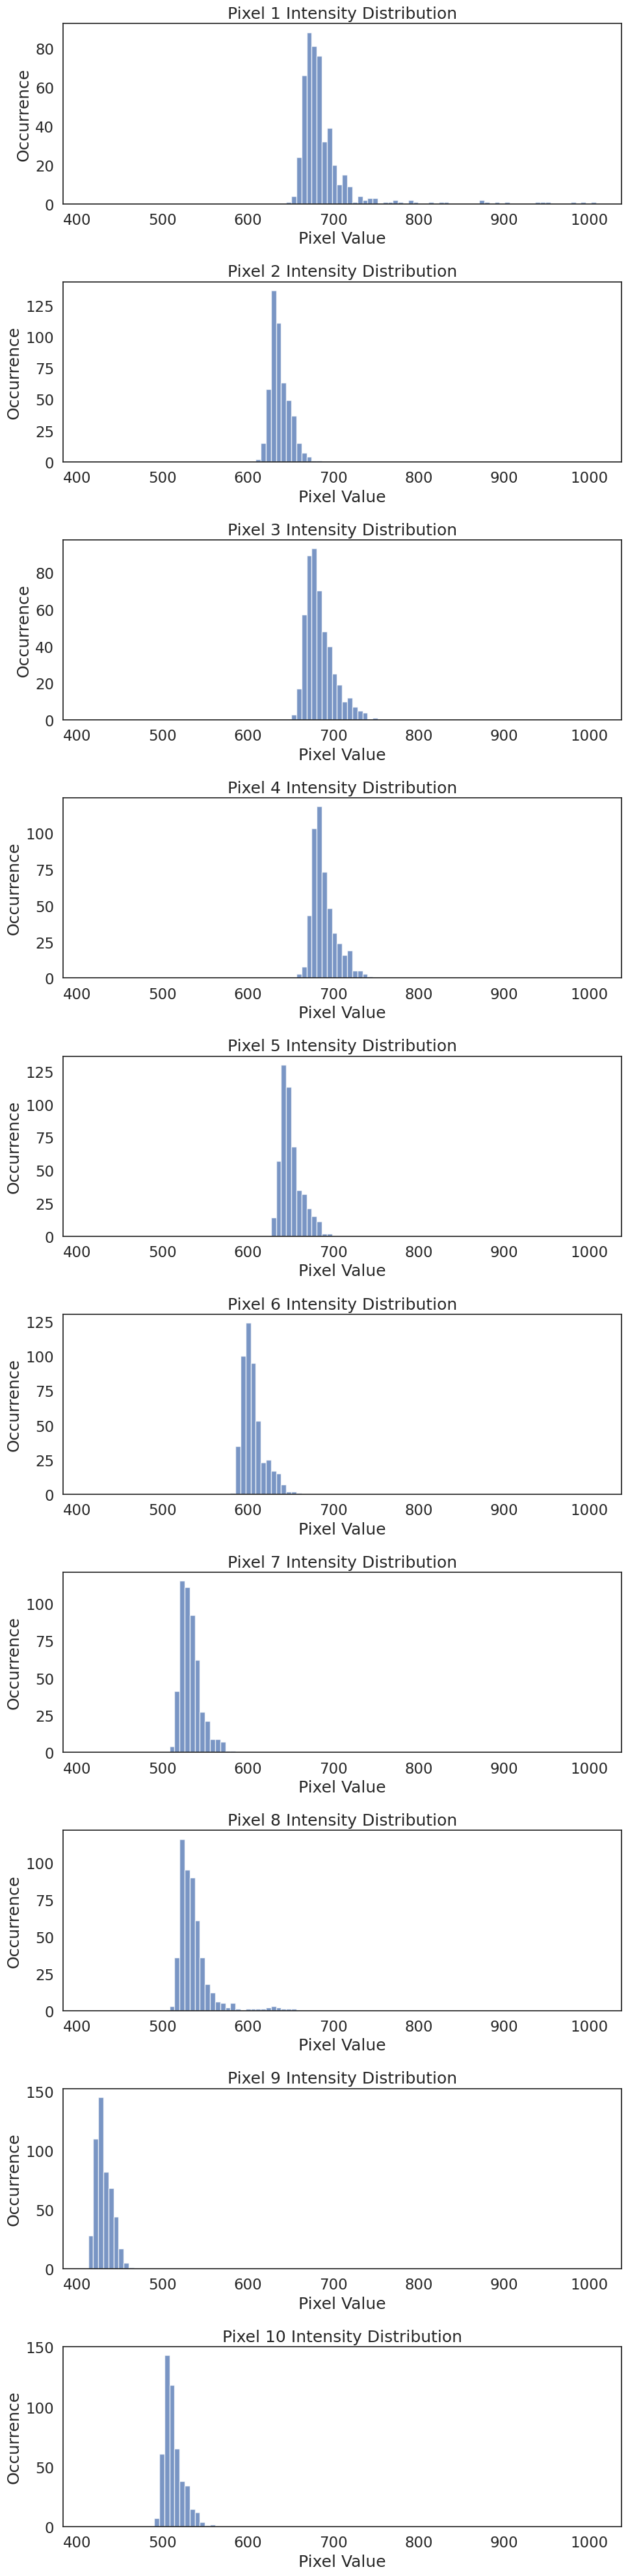

In [109]:
fig, axs = plt.subplots(len(rnd_pix.T), 1, figsize=(10, 40))
global_min = min([values.min() for values in rnd_pix.T])
global_max = max([values.max() for values in rnd_pix.T])
for i, values in enumerate(rnd_pix.T):
    axs[i].hist(values, bins=100, alpha=0.75, range=(global_min, global_max))
    axs[i].set_title(f"Pixel {i+1} Intensity Distribution")
    axs[i].set_xlabel('Pixel Value')
    axs[i].set_ylabel('Occurrence')

plt.tight_layout()
plt.show()

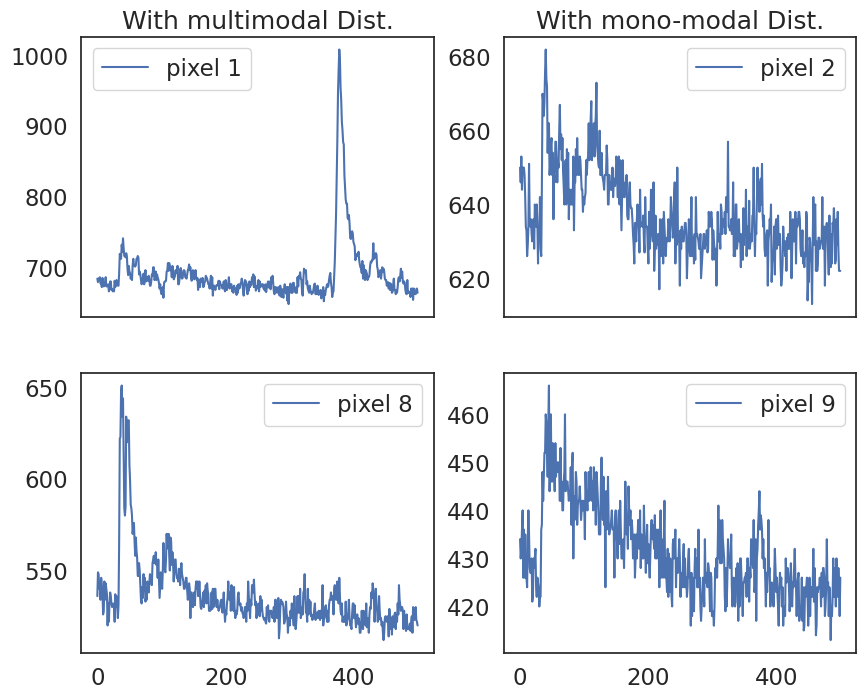

In [118]:
fig, ax = plt.subplots(2,2, figsize=(10, 8), sharex=True)
ax[0,0].set_title("With multimodal Dist.")
ax[0,0].plot(rnd_pix.T[0], label="pixel 1")
ax[0,0].legend()
ax[1,0].plot(rnd_pix.T[7], label="pixel 8")
ax[1,0].legend()
ax[0,1].set_title("With mono-modal Dist.")
ax[0,1].plot(rnd_pix.T[1], label="pixel 2")
ax[0,1].legend()
ax[1,1].plot(rnd_pix.T[8], label="pixel 9")
ax[1,1].legend()

Pixels that belong to the background have histograms with a narrow distribution centered around a specific range of intensity values, while neurons show more variation and have sometimes multimodal histograms. <br><br>
The problems I can think of by only relying on this to distinguish neurons from backround are: <br>
**Noise:**Neuronal activity results in changes in fluorescence and can spread over several pixels. This creates noise. A source extraction algorithms can integrate the signal from multiple pixels and reduces this problem.<br>
**Spatial Information:** Neurons will take more than one pixel of space in an image. So just looking at one pixel will not give all the spatial availabel information about a certain neuron.

## Exercise 2: motion correction parameters
---

One parameter that impacts motion correction performance is the size of the spatial filter that is applyed to the video.

* Use the following function from CaImAn and plot the result of different space filtering applyed to a single frame of the video:from caiman.motion_correction import high_pass_filter_space

* How will this filtering affect the measure of crispness?

* Acording to Pnevmatikakis et al, which other factors are relevant for pw-rigid motion correction?

- Explore the impact of different parameters in the output of motion correction algorithm by measuring crispness in the correlation image of the final outcome. Particularly measure the effect of different spatial filter size by applying motion correction algorithm multiple times and computing the crispness of the output video.

- Display all crispness values for rigid and not rigid motion correction and plot them agains gSig_filters values.

- If possible, show the impact of the crispness value that comes from changing other relevant paraments.

*Note1: The is no need to save all the motion corrected movies, just save the cripsness values.*

*Note2: gSig_filters is an optional range of posible values, but if your computer gets to slow in the computation reduce the range.*


## Exercise 3: Source extraction parameters
---

* For a fixed minimum correlation value (ie 0.6) select a range of possible PNR minimun values and study the impact of those in the final source extraction output.

* For a fixed value of PNR (ie 6) select a range of minimum correlation valur and study the impact of those in the final source extraction output.

* How do these paramenters affect the spatial sparcity of the output? Which set of parameter selection procedes the higher number of neurons? Is maximal number of neurons always better? Why?  

* Generate a plot of number of neurons vs PNR (or min corr value) to show how these parameters affect the source extracted signals.

* Are the temporal traces affected by these parameters?

* For different PNR and minimum correlation value plot the correlation image and the selected cells.